In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
import tflearn
from utils import *
from model_graph import densenet_mnist
from itertools import cycle
os.environ["CUDA_VISIBLE_DEVICES"]='0'
mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs')
targets = tf.placeholder(tf.float32, [None, 10], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')
shortcut_flag = tf.placeholder(tf.bool, name='shortcut')

In [3]:
output, feature_transform = densenet_mnist(inputs, 10, 40, 12, 1.0,
                                     train_flag,shortcut_flag, input_shortcut)

In [4]:
#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))

step_adam = tf.train.AdamOptimizer(1e-4).minimize(cost)
step_momentum = tf.train.MomentumOptimizer(0.01, 0.9).minimize(cost)
step_gd = tf.train.GradientDescentOptimizer(0.0001).minimize(cost)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

step_sgd_previous_layer = tf.train.GradientDescentOptimizer(0.0001).minimize(cost,
                        var_list = previous_layer_variables)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-4)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
optimizer_m_last_layer = tf.train.MomentumOptimizer(1e-4, 0.9)
step_m_last_layer = optimizer_m_last_layer.minimize(cost,
                        var_list = last_layer_variables)


# optimizer = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

In [55]:
batch_size = 256
def optimize(optimizer_step, epochs):

    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()
        for ii in range(mnist_data.train.num_examples//batch_size):
            batch = mnist_data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            labs = batch[1]

            dict_input = {inputs:imgs, targets:labs, 
                          train_flag: True, 
                          shortcut_flag: False,
                          input_shortcut: np.zeros([batch_size, 2])}

            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoch: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%100==0:
            saver.save(session,'../model/mnist_densenet_10_class_mom_{}.ckpt'.format(i))

In [56]:
optimize(step_momentum, 1001)

('Epoch: 1/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00193927530199', ' | Time for epoch: 81.26s')
('Epoch: 2/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00245688809082', ' | Time for epoch: 82.91s')
('Epoch: 3/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00256832246669', ' | Time for epoch: 84.50s')
('Epoch: 4/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00218947185203', ' | Time for epoch: 85.36s')
('Epoch: 5/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00215068482794', ' | Time for epoch: 84.81s')
('Epoch: 6/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00218554935418', ' | Time for epoch: 83.90s')
('Epoch: 7/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00231116404757', ' | Time for epoch: 85.01s')
('Epoch: 8/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0021285621915', ' | Time for epoch: 84.27s')
('Epoch: 9/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00226741284132', ' | Time for epoch: 84.58s')
('Epoch: 10/1001', '| Training accuracy: ', 1.0, '| Cost

('Epoch: 79/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00573846884072', ' | Time for epoch: 84.52s')
('Epoch: 80/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00273771141656', ' | Time for epoch: 84.18s')
('Epoch: 81/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0025144002866', ' | Time for epoch: 83.66s')
('Epoch: 82/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00228012329899', ' | Time for epoch: 83.87s')
('Epoch: 83/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00181762920693', ' | Time for epoch: 83.68s')
('Epoch: 84/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00192112580407', ' | Time for epoch: 84.20s')
('Epoch: 85/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00189224944916', ' | Time for epoch: 84.33s')
('Epoch: 86/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00173494569026', ' | Time for epoch: 83.56s')
('Epoch: 87/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00169845891651', ' | Time for epoch: 84.15s')
('Epoch: 88/1001', '| Training accuracy: ', 1.0

('Epoch: 156/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00109885446727', ' | Time for epoch: 84.71s')
('Epoch: 157/1001', '| Training accuracy: ', 1.0, '| Cost: 0.001087379409', ' | Time for epoch: 84.30s')
('Epoch: 158/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00136457092594', ' | Time for epoch: 84.49s')
('Epoch: 159/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000814644095954', ' | Time for epoch: 84.23s')
('Epoch: 160/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00107971543912', ' | Time for epoch: 84.15s')
('Epoch: 161/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00106827961281', ' | Time for epoch: 84.43s')
('Epoch: 162/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00105535041075', ' | Time for epoch: 84.38s')
('Epoch: 163/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00133104703855', ' | Time for epoch: 84.54s')
('Epoch: 164/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000903739826754', ' | Time for epoch: 84.43s')
('Epoch: 165/1001', '| Training accur

('Epoch: 233/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000757654779591', ' | Time for epoch: 84.45s')
('Epoch: 234/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000773974694312', ' | Time for epoch: 84.41s')
('Epoch: 235/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0007357171271', ' | Time for epoch: 84.39s')
('Epoch: 236/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00074039248284', ' | Time for epoch: 84.48s')
('Epoch: 237/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0007153491606', ' | Time for epoch: 84.49s')
('Epoch: 238/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000845094851684', ' | Time for epoch: 84.51s')
('Epoch: 239/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000571460463107', ' | Time for epoch: 84.46s')
('Epoch: 240/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000830831355415', ' | Time for epoch: 84.46s')
('Epoch: 241/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000563079898711', ' | Time for epoch: 84.45s')
('Epoch: 242/1001', '| Training a

('Epoch: 309/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000662263424601', ' | Time for epoch: 84.15s')
('Epoch: 310/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000384393613786', ' | Time for epoch: 84.55s')
('Epoch: 311/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000518524437211', ' | Time for epoch: 84.24s')
('Epoch: 312/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000655045907479', ' | Time for epoch: 84.70s')
('Epoch: 313/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000373645714717', ' | Time for epoch: 84.65s')
('Epoch: 314/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000653463415802', ' | Time for epoch: 84.34s')
('Epoch: 315/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000378175638616', ' | Time for epoch: 85.03s')
('Epoch: 316/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000505075149704', ' | Time for epoch: 84.79s')
('Epoch: 317/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000510782236233', ' | Time for epoch: 84.90s')
('Epoch: 318/1001', '| Train

('Epoch: 385/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000682670448441', ' | Time for epoch: 84.71s')
('Epoch: 386/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000661216734443', ' | Time for epoch: 84.27s')
('Epoch: 387/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000492773484439', ' | Time for epoch: 83.81s')
('Epoch: 388/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000749489408918', ' | Time for epoch: 83.54s')
('Epoch: 389/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000468289799755', ' | Time for epoch: 84.24s')
('Epoch: 390/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000585480825976', ' | Time for epoch: 83.67s')
('Epoch: 391/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000593692297116', ' | Time for epoch: 83.85s')
('Epoch: 392/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000584737572353', ' | Time for epoch: 83.95s')
('Epoch: 393/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00070504512405', ' | Time for epoch: 84.42s')
('Epoch: 394/1001', '| Traini

('Epoch: 461/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000430203072028', ' | Time for epoch: 84.59s')
('Epoch: 462/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000424336612923', ' | Time for epoch: 84.58s')
('Epoch: 463/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000566800765228', ' | Time for epoch: 84.33s')
('Epoch: 464/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000424343685154', ' | Time for epoch: 84.36s')
('Epoch: 465/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00027851035702', ' | Time for epoch: 84.20s')
('Epoch: 466/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000420410709921', ' | Time for epoch: 84.06s')
('Epoch: 467/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000416144728661', ' | Time for epoch: 84.39s')
('Epoch: 468/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000418584677391', ' | Time for epoch: 83.96s')
('Epoch: 469/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000416924391175', ' | Time for epoch: 83.62s')
('Epoch: 470/1001', '| Traini

('Epoch: 537/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000227847864153', ' | Time for epoch: 84.35s')
('Epoch: 538/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000373589544324', ' | Time for epoch: 84.34s')
('Epoch: 539/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000372699199943', ' | Time for epoch: 84.55s')
('Epoch: 540/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000371198286302', ' | Time for epoch: 84.39s')
('Epoch: 541/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000515669235028', ' | Time for epoch: 84.50s')
('Epoch: 542/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000221762427827', ' | Time for epoch: 84.76s')
('Epoch: 543/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000368623324903', ' | Time for epoch: 84.51s')
('Epoch: 544/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000366463558748', ' | Time for epoch: 84.91s')
('Epoch: 545/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000367936328985', ' | Time for epoch: 84.47s')
('Epoch: 546/1001', '| Train

('Epoch: 613/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000191504950635', ' | Time for epoch: 84.45s')
('Epoch: 614/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000339763151715', ' | Time for epoch: 85.10s')
('Epoch: 615/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00034106062958', ' | Time for epoch: 84.12s')
('Epoch: 616/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000338714453392', ' | Time for epoch: 83.96s')
('Epoch: 617/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000341197592206', ' | Time for epoch: 84.31s')
('Epoch: 618/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000343445455655', ' | Time for epoch: 84.40s')
('Epoch: 619/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000337487319484', ' | Time for epoch: 84.15s')
('Epoch: 620/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000337763514835', ' | Time for epoch: 84.34s')
('Epoch: 621/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000338384270435', ' | Time for epoch: 84.35s')
('Epoch: 622/1001', '| Traini

('Epoch: 689/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000319521001074', ' | Time for epoch: 83.66s')
('Epoch: 690/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000468826532597', ' | Time for epoch: 84.48s')
('Epoch: 691/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00031750954804', ' | Time for epoch: 83.94s')
('Epoch: 692/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000317789032124', ' | Time for epoch: 84.42s')
('Epoch: 693/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00016996798513', ' | Time for epoch: 84.44s')
('Epoch: 694/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00031928968383', ' | Time for epoch: 84.09s')
('Epoch: 695/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000320969265886', ' | Time for epoch: 84.39s')
('Epoch: 696/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000467254867544', ' | Time for epoch: 84.31s')
('Epoch: 697/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000166298195836', ' | Time for epoch: 84.41s')
('Epoch: 698/1001', '| Training

('Epoch: 765/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00014675752027', ' | Time for epoch: 84.61s')
('Epoch: 766/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000299773819279', ' | Time for epoch: 84.26s')
('Epoch: 767/1001', '| Training accuracy: ', 0.99609375, '| Cost: 0.000453056651168', ' | Time for epoch: 84.75s')
('Epoch: 768/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000147030572407', ' | Time for epoch: 84.68s')
('Epoch: 769/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000452112784842', ' | Time for epoch: 83.88s')
('Epoch: 770/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000145528945723', ' | Time for epoch: 84.69s')
('Epoch: 771/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000450910185464', ' | Time for epoch: 84.34s')
('Epoch: 772/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000299801060464', ' | Time for epoch: 84.64s')
('Epoch: 773/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000144377336255', ' | Time for epoch: 84.67s')
('Epoch: 774/1001', '|

('Epoch: 841/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00051162368618', ' | Time for epoch: 80.84s')
('Epoch: 842/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000204165407922', ' | Time for epoch: 80.86s')
('Epoch: 843/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000357014563633', ' | Time for epoch: 80.90s')
('Epoch: 844/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000359917466994', ' | Time for epoch: 80.81s')
('Epoch: 845/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00041762550245', ' | Time for epoch: 80.91s')
('Epoch: 846/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000355897267582', ' | Time for epoch: 80.84s')
('Epoch: 847/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000358696852345', ' | Time for epoch: 80.82s')
('Epoch: 848/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000499145884532', ' | Time for epoch: 80.82s')
('Epoch: 849/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000187963043572', ' | Time for epoch: 80.85s')
('Epoch: 850/1001', '| Trainin

('Epoch: 917/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000143172990647', ' | Time for epoch: 84.41s')
('Epoch: 918/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0002987642074', ' | Time for epoch: 84.36s')
('Epoch: 919/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00029906121199', ' | Time for epoch: 84.16s')
('Epoch: 920/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000297751743346', ' | Time for epoch: 84.31s')
('Epoch: 921/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000302628905047', ' | Time for epoch: 84.20s')
('Epoch: 922/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000456195208244', ' | Time for epoch: 84.92s')
('Epoch: 923/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000143633165862', ' | Time for epoch: 83.86s')
('Epoch: 924/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000296303885989', ' | Time for epoch: 84.11s')
('Epoch: 925/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000297117599985', ' | Time for epoch: 83.91s')
('Epoch: 926/1001', '| Training

('Epoch: 993/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000282360997517', ' | Time for epoch: 84.87s')
('Epoch: 994/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000282014341792', ' | Time for epoch: 85.57s')
('Epoch: 995/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00028216431383', ' | Time for epoch: 85.56s')
('Epoch: 996/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000282488355879', ' | Time for epoch: 85.64s')
('Epoch: 997/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000280709209619', ' | Time for epoch: 85.54s')
('Epoch: 998/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000281386688584', ' | Time for epoch: 85.73s')
('Epoch: 999/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000282138469629', ' | Time for epoch: 85.59s')
('Epoch: 1000/1001', '| Training accuracy: ', 1.0, '| Cost: 0.000282249704469', ' | Time for epoch: 85.57s')
('Epoch: 1001/1001', '| Training accuracy: ', 1.0, '| Cost: 0.00045578830759', ' | Time for epoch: 85.54s')


In [57]:
# check the test dataset performance
acc_list = []
for ii in range(mnist_data.test.num_examples//batch_size):
    batch = mnist_data.test.next_batch(batch_size)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]

    dict_input = {inputs:imgs, targets:labs, 
                  train_flag: False, 
                  shortcut_flag: False,
                  input_shortcut: np.zeros([batch_size, 2])}

    acc = session.run(accuracy, feed_dict=dict_input)
    acc_list.append(acc)
print("Test accuracy: {}".format(np.mean(acc_list)))

Test accuracy: 0.992888629436


In [65]:
def plot_temp_all(feature, label, feature_t, label_t, 
                    name=None):
    pylab.figure()
    color_list = ['k', 'grey', 'lightgray', 'lightcoral', 'maroon',
                 'mistyrose', 'coral', 'orange','darkgoldenrod',
                 'olive', 'yellow', 'm', 'g', 'c','cadetblue',
                 'dodgerblue','slateblue','violet','darkred','r']
    points_random = list()
    points_t = list()
    for i in range(10):
        points_random.append(feature[label==i])
        points_t.append(feature_t[label_t==i])

    for i in range(10):
        pylab.scatter(points_random[i][:,0], points_random[i][:,1],
                      c=color_list[i], marker='o')
        pylab.scatter(points_t[i][:,0], points_t[i][:,1], 
                      c=color_list[i+10], marker='o')
    pylab.xticks(fontsize=17)
    pylab.yticks(fontsize=17)
    if name==None:
        pylab.show()
    else:
        pylab.savefig(name)
        
def random_points_10(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(10,size)
	return feature, label

def get_svm(feature, label):
    from sklearn.svm import LinearSVC
    clf = LinearSVC(multi_class='ovr')
    clf.fit(feature, label)
    return clf

def plot_blobs(feature_t, label_t, 
                    name=None):
    pylab.figure()

    color_list = ['k', 'grey', 'lightgray', 'lightcoral', 'maroon',
                 'mistyrose', 'coral', 'orange','darkgoldenrod',
                 'olive', 'yellow', 'm', 'g', 'c','cadetblue',
                 'dodgerblue','slateblue','violet','darkred','r']
    points_t = list()
    for i in range(10):
        points_t.append(feature_t[label_t==i])

    for i in range(10):
        try:
            pylab.scatter(points_t[i][:,0], points_t[i][:,1], 
                          c=color_list[i], marker='.')
        except:
            print i
    pylab.xticks(fontsize=17)
    pylab.yticks(fontsize=17)
    if name==None:
        pylab.show()
    else:
        pylab.savefig(name)

In [59]:
feature_t = []
label_t = []

for ii in range(mnist_data.train.num_examples//batch_size):
    batch = mnist_data.train.next_batch(batch_size)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    label_t.append(labs)
    
    dict_input = {inputs:imgs, targets:labs, 
                  train_flag: False, 
                  shortcut_flag: False,
                  input_shortcut: np.zeros([batch_size, 2])}

    feature_t.append(session.run(feature_transform, feed_dict=dict_input))

label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)

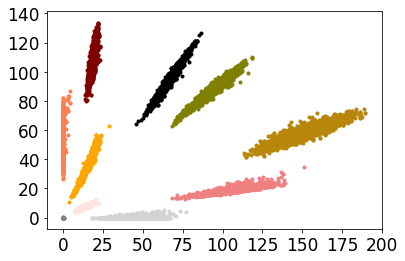

In [60]:
plot_blobs(feature_t, label_t)

# transformed space

In [66]:
feature_random, label_random = random_points_10(-10,
    210,-10,140, 30000,
    random_state=100)
label_random = to_categorical(label_random, 10)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:imgs, 
               targets:label_random,
               train_flag: False, 
               shortcut_flag: True,
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

In [ ]:
plot_temp_all(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all(feature_random, pre_label_svm,feature_t, label_t)

In [ ]:
plot_temp_all(feature_random, pre_label_nn,feature_t, label_t, '../result/mnist_3_class_densenet/nn_transformed.png')
plot_temp_all(feature_random, pre_label_svm,feature_t, label_t, '../result/mnist_3_class_densenet/svm_transformed.png')